In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from math import sqrt, log, exp
from scipy.stats import norm
from abc import ABC, abstractmethod

***1) Classes pour les options***

In [35]:
"""
La classe option est une classe abstraite dont la méthode price est redéfinie dans les classes filles Call et Put.
"""

class Option(ABC):

    def __init__(self, S, T, K, r, q, sigma, position = 1):
        self.S = S
        self.T = T
        self.K = K
        self.r = r
        self.q = q
        self.sigma = sigma
        self.position = position # 1 pour long, -1 pour short
    
    def dplus(self):
        return (log(self.S/self.K) + (self.r - self.q + 0.5 * self.sigma**2) * self.T) / (self.sigma * sqrt(self.T))
    
    def dminus(self):
        return self.dplus() - self.sigma * sqrt(self.T)
    
    @abstractmethod
    def payoff(self):
        pass

    @abstractmethod
    def price(self):
        pass

    @abstractmethod
    def delta(self):
        pass

    @abstractmethod
    def gamma(self):
        pass

    @abstractmethod
    def theta(self):
        pass

    @abstractmethod
    def vega(self):
        pass


"""La classe Call hérite de la classe Option et redéfinit les méthodes abstraites pour un call."""  
class Call(Option):

    def payoff(self):
        return self.position*max(self.S - self.K, 0)

    def price(self):
        d1 = Option.dplus(self)
        d2 = Option.dminus(self)
        return self.position*(self.S * exp(-self.q * self.T) * norm.cdf(d1) - self.K * exp(-self.r * self.T) * norm.cdf(d2))
    
    def delta(self):
        return exp(-self.q * self.T) * norm.cdf(Option.dplus(self))
    
    def gamma(self):
        return exp(-self.q * self.T) * norm.pdf(Option.dplus(self)) / (self.S * self.sigma * sqrt(self.T))
    
    def theta(self):
        d1 = Option.dplus(self)
        d2 = Option.dminus(self)
        return -self.S * exp(-self.q * self.T) * norm.pdf(d1) * self.sigma / (2 * sqrt(self.T)) - self.r * self.K * exp(-self.r * self.T) * norm.cdf(d2) + self.q * self.S * exp(-self.q * self.T) * norm.cdf(d1)
    
    def vega(self):
        return self.S * exp(-self.q * self.T) * norm.pdf(Option.dplus(self)) * sqrt(self.T)
    

class Put(Option):

    def payoff(self):
        return max(self.K - self.S, 0)

    def price(self):
        d1 = Option.dplus(self)
        d2 = Option.dminus(self)
        return self.K * exp(-self.r * self.T) * norm.cdf(-d2) - self.S * exp(-self.q * self.T) * norm.cdf(-d1)
    
    def delta(self):
        return -exp(-self.q * self.T) * norm.cdf(-Option.dplus(self))
    
    def gamma(self):
        return exp(-self.q * self.T) * norm.pdf(Option.dplus(self)) / (self.S * self.sigma * sqrt(self.T))
    
    def theta(self):
        d1 = Option.dplus(self)
        d2 = Option.dminus(self)
        return -self.S * exp(-self.q * self.T) * norm.pdf(d1) * self.sigma / (2 * sqrt(self.T)) + self.r * self.K * exp(-self.r * self.T) * norm.cdf(-d2) - self.q * self.S * exp(-self.q * self.T) * norm.cdf(-d1)
    
    def vega(self):
        return self.S * exp(-self.q * self.T) * norm.pdf(Option.dplus(self)) * sqrt(self.T)


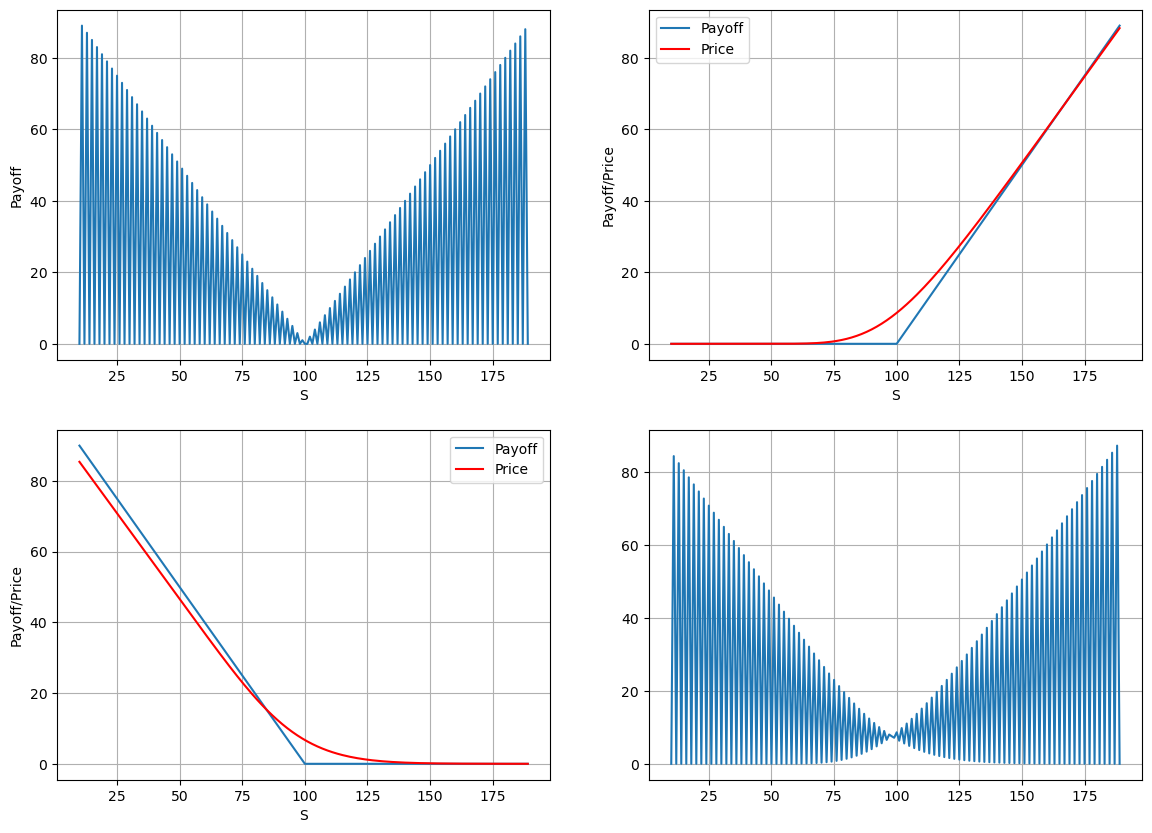

In [36]:
T, K, r, q, sigma = 1, 100, 0.05, 0.03, 0.2
options = []
for s in range(10, 190):
    if s%2 == 0:
        options.append(Call(s, T, K, r, q, sigma))
    else: 
        options.append(Put(s, T, K, r, q, sigma))

#Intérerêt de la méthode abstraite dans la classe Option
payoffs = [option.payoff() for option in options]
prices = [option.price() for option in options]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for ax in axs.flat:
    ax.grid(True)

axs[0, 0].plot(range(10, 190), payoffs)
axs[0, 0].set_xlabel('S')
axs[0, 0].set_ylabel('Payoff')

calls = [Call(s, T, K, r, q, sigma) for s in range(10, 190)]
calls_prices = [call.price() for call in calls]
call_payoffs = [call.payoff() for call in calls]
axs[0, 1].plot(range(10, 190), call_payoffs)
axs[0, 1].plot(range(10, 190), calls_prices, 'r')
axs[0, 1].set_xlabel('S')
axs[0, 1].set_ylabel('Payoff/Price')
axs[0, 1].legend(['Payoff', 'Price'])

puts = [Put(s, T, K, r, q, sigma) for s in range(10, 190)]
puts_prices = [put.price() for put in puts]
put_payoffs = [put.payoff() for put in puts]
axs[1, 0].plot(range(10, 190), put_payoffs)
axs[1, 0].plot(range(10, 190), puts_prices, 'r')
axs[1, 0].set_xlabel('S')
axs[1, 0].set_ylabel('Payoff/Price')
axs[1, 0].legend(['Payoff', 'Price'])

axs[1, 1].plot(range(10, 190), prices)


***2) Classes pour les sratégies***

In [40]:
class Strategie(ABC):

    def __init__(self, options = []):
        self.options = options
    
    def calculate_payoff(self):
        return sum([option.payoff() for option in self.options])
    
    def calculate_price(self):
        return sum([option.price() for option in self.options])


class Straddle(Strategie):
    
    def __init__(self, S, T, K, r, q, sigma):
        self.options = [Call(S, T, K, r, q, sigma), Put(S, T, K, r, q, sigma)]


class Strangle(Strategie):
    
    def __init__(self, S, T, K1, K2, r, q, sigma):
        self.options = [Call(S, T, K1, r, q, sigma), Put(S, T, K2, r, q, sigma)]


class Butterfly(Strategie):

    def __init__(self, S, T, K1, K2, K3, r, q, sigma):
        self.options = [Call(S, T, K1, r, q, sigma), Call(S, T, K3, r, q, sigma), Call(S, T, K2, r, q, sigma, -1), Call(S, T, K2, r, q, sigma, -1)]

class BullSpread(Strategie):

    def __init__(self, S, T, K1, K2, r, q, sigma):
        self.options = [Call(S, T, K1, r, q, sigma), Call(S, T, K2, r, q, sigma, -1)]

class BearSpread(Strategie):
    
    def __init__(self, S, T, K1, K2, r, q, sigma):
            self.options = [Call(S, T, K1, r, q, sigma, -1), Call(S, T, K2, r, q, sigma)]

Text(0, 0.5, 'Payoff/Price')

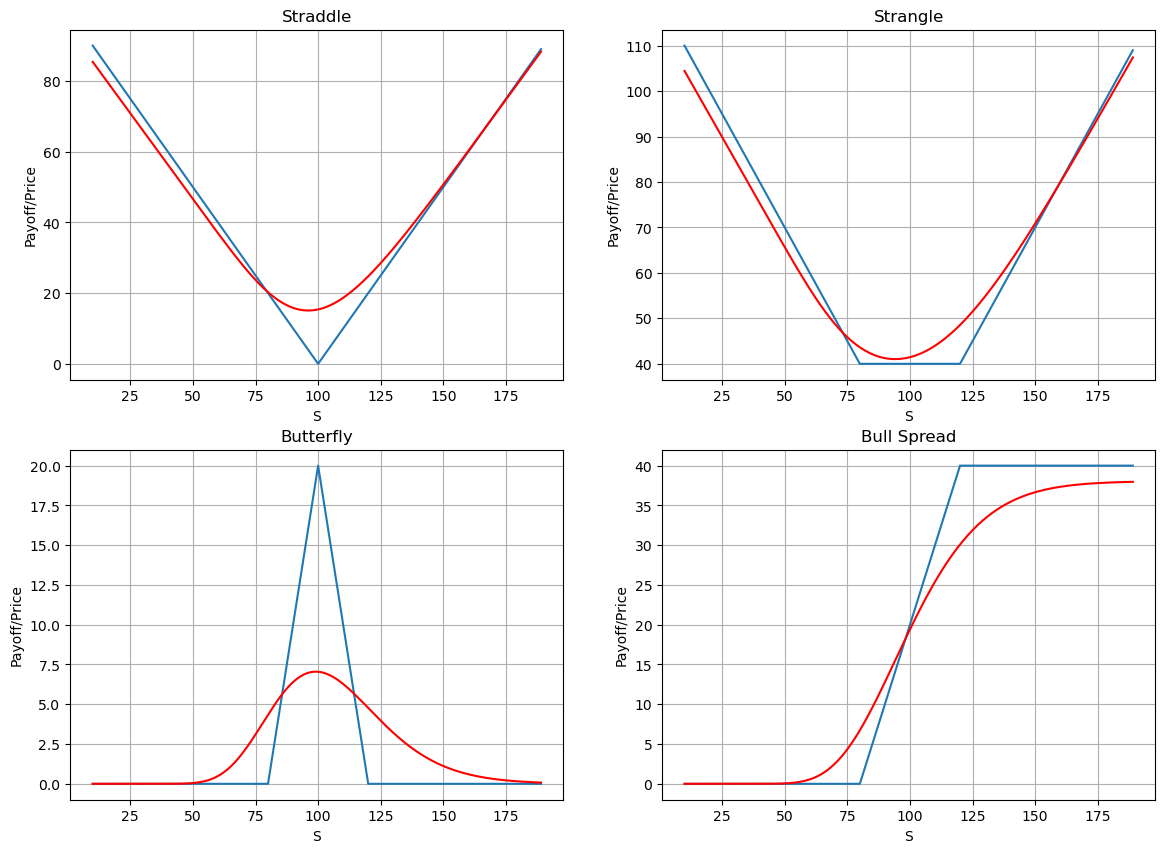

In [42]:
strad1 = [Straddle(s, 1, 100, 0.05, 0.03, 0.2) for s in range(10, 190)]
payoffs_strad = [strad.calculate_payoff() for strad in strad1]
prices_strad = [strad.calculate_price() for strad in strad1]

strang1 = [Strangle(s, 1, 80, 120, 0.05, 0.03, 0.2) for s in range(10, 190)]
payoffs_strang = [strang.calculate_payoff() for strang in strang1]
prices_strang = [strang.calculate_price() for strang in strang1]

butter1 = [Butterfly(s, 1, 80, 100, 120, 0.05, 0.03, 0.2) for s in range(10, 190)]
payoffs_butter = [butter.calculate_payoff() for butter in butter1]
prices_butter = [butter.calculate_price() for butter in butter1]

bull1 = [BullSpread(s, 1, 80, 120, 0.05, 0.03, 0.2) for s in range(10, 190)]
payoffs_bull = [bull.calculate_payoff() for bull in bull1]
prices_bull = [bull.calculate_price() for bull in bull1]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for ax in axs.flat:
    ax.grid(True)

axs[0, 0].plot(range(10, 190), payoffs_strad)
axs[0, 0].plot(range(10, 190), prices_strad, 'r')
axs[0, 0].set_title('Straddle')
axs[0, 0].set_xlabel('S')
axs[0, 0].set_ylabel('Payoff/Price')

axs[0, 1].plot(range(10, 190), payoffs_strang)
axs[0, 1].plot(range(10, 190), prices_strang, 'r')
axs[0, 1].set_title('Strangle')
axs[0, 1].set_xlabel('S')
axs[0, 1].set_ylabel('Payoff/Price')

axs[1, 0].plot(range(10, 190), payoffs_butter)
axs[1, 0].plot(range(10, 190), prices_butter, 'r')
axs[1, 0].set_title('Butterfly')
axs[1, 0].set_xlabel('S')
axs[1, 0].set_ylabel('Payoff/Price')

axs[1, 1].plot(range(10, 190), payoffs_bull)
axs[1, 1].plot(range(10, 190), prices_bull, 'r')
axs[1, 1].set_title('Bull Spread')
axs[1, 1].set_xlabel('S')
axs[1, 1].set_ylabel('Payoff/Price')
